In [98]:
### Import necessary packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import tensorflow as tf
import tensorflow_hub as hub

from IPython.display import Image
import os

from sklearn.datasets import load_files       
import glob
from glob import glob
from tqdm import tqdm

import cv2
import PIL
from PIL import ImageFile
import matplotlib.pyplot as plt                        
%matplotlib inline 

import keras
from keras.utils import np_utils
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions 
from keras.preprocessing import image        


print(keras.__version__)

2.3.1


In [2]:
### Check for GPU availability
if tf.config.list_physical_devices('GPU'):
  print("GPU is available.")
else:
  print("GPU is NOT available.")

GPU is NOT available.


In [3]:
# Checkout the labels of our data
import pandas as pd
labels_csv = pd.read_csv("targets_df.csv", index_col = 0)
print(labels_csv.describe())
print(labels_csv.head())

                        filename    breed
count                      28666    28666
unique                     28666      173
top     p7q5hs9g1mwvyc34fj2z.jpg  maltese
freq                           1      312
                   filename    breed
0  m8045hqkl3wiado97pcb.jpg  maltese
1  51n7gcvmu9x2e8wfoql6.jpg  maltese
2  its279rcqnjuz6eao03w.jpg  maltese
3  mzhr9l61d3j4sqogbu5n.jpg  maltese
4  wurbzx6jnvgep8d4mao2.jpg  maltese


In [4]:
labels_csv.head(5)

,filename,breed
0,m8045hqkl3wiado97pcb.jpg,maltese
1,51n7gcvmu9x2e8wfoql6.jpg,maltese
2,its279rcqnjuz6eao03w.jpg,maltese
3,mzhr9l61d3j4sqogbu5n.jpg,maltese
4,wurbzx6jnvgep8d4mao2.jpg,maltese


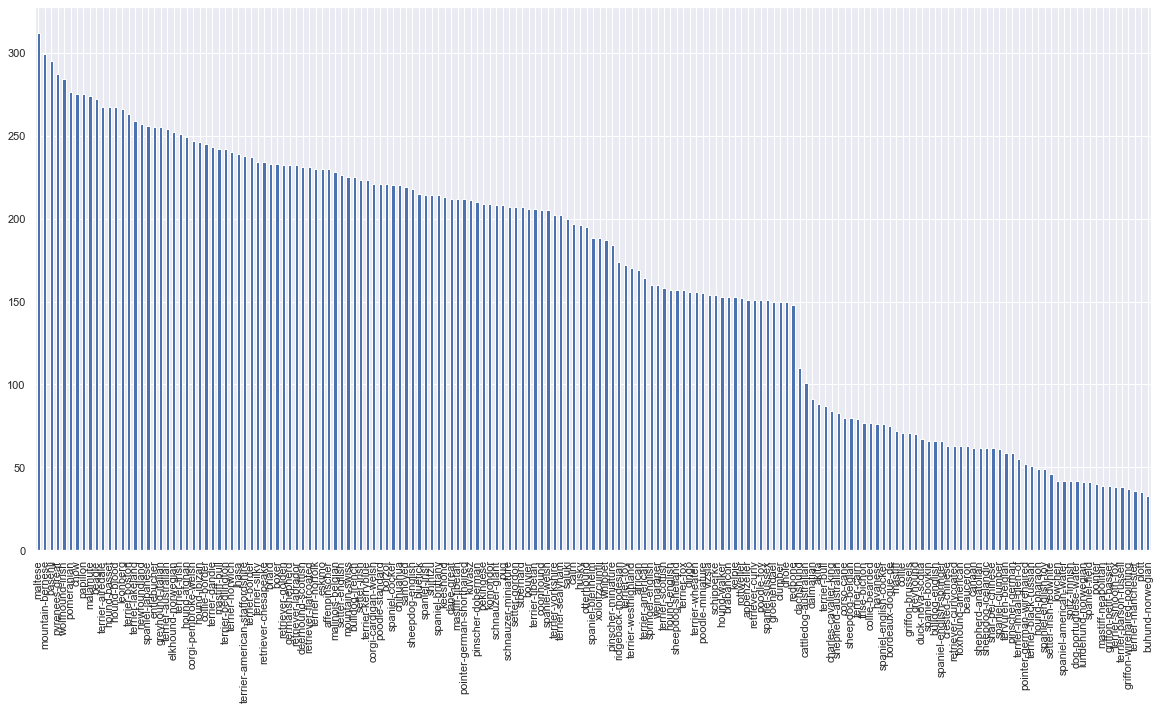

In [5]:
# How many images are there of each breed?
labels_csv["breed"].value_counts().plot.bar(figsize=(20, 10));

In [6]:
# Create pathnames from image ID's
filenames = ["images/train/" + fname for fname in labels_csv["filename"]]

# Check the first 10 filenames
filenames[:10]

['images/train/m8045hqkl3wiado97pcb.jpg',
 'images/train/51n7gcvmu9x2e8wfoql6.jpg',
 'images/train/its279rcqnjuz6eao03w.jpg',
 'images/train/mzhr9l61d3j4sqogbu5n.jpg',
 'images/train/wurbzx6jnvgep8d4mao2.jpg',
 'images/train/utfn8e90pmd4kqhwryia.jpg',
 'images/train/olb3uhx4m8ya1w97detk.jpg',
 'images/train/37jyl4harcxeqfbzv9tn.jpg',
 'images/train/p8w10ol6xdh3g2j7kas9.jpg',
 'images/train/60woienh34x5yzjt29gf.jpg']

In [7]:
# Check whether number of filenames matches number of actual image files
import os
if len(os.listdir("images/train/")) == len(filenames):
  print("Filenames match actual amount of files!")
else:
  print("Filenames do not match actual amount of files, check the target directory.")

Filenames match actual amount of files!


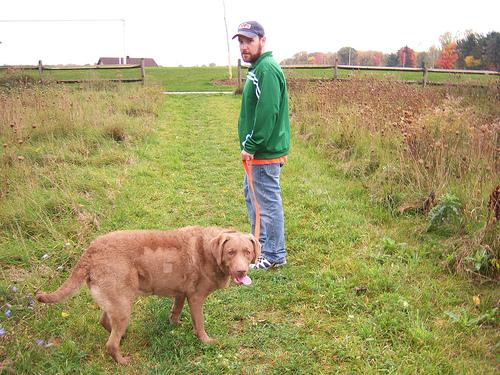

In [8]:
# Check an image directly from a filepath
Image(filenames[9000])

In [9]:
labels = labels_csv["breed"].to_numpy() # convert labels column to NumPy array
labels[:10]

array(['maltese', 'maltese', 'maltese', 'maltese', 'maltese', 'maltese',
       'maltese', 'maltese', 'maltese', 'maltese'], dtype=object)

In [10]:
# Find the unique label values
unique_breeds = np.unique(labels)
len(unique_breeds)

173

In [11]:
# Example: Turn one label into an array of booleans
print(labels[0])
labels[0] == unique_breeds # use comparison operator to create boolean array

maltese


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [12]:
# Turn every label into a boolean array
boolean_labels = [label == np.array(unique_breeds) for label in labels]
boolean_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False,  True,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
      

In [16]:
# Example: Turning a boolean array into integers
print(labels[0]) # original label
print(np.where(unique_breeds == labels[0])[0][0]) # index where label occurs
print(boolean_labels[0].argmax()) # index where label occurs in boolean array
print(boolean_labels[0].astype(int)) # there will be a 1 where the sample label occurs

maltese
71
71
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [17]:
# Setup X & y variables
X = filenames
y = boolean_labels

In [18]:
# Set number of images to use for experimenting
NUM_IMAGES = 20000 #@param {type:"slider", min:1000, max:10000, step:1000}
NUM_IMAGES

20000

In [19]:
# Import train_test_split from Scikit-Learn
from sklearn.model_selection import train_test_split

# Split them into training and validation using NUM_IMAGES 
X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES],
                                                  y[:NUM_IMAGES], 
                                                  test_size=0.2,
                                                  random_state=42)

len(X_train), len(y_train), len(X_val), len(y_val)

(16000, 16000, 4000, 4000)

In [20]:
# Check out the training data (image file paths and labels)
X_train[:5], y_train[:2]

(['images/train/aubiv2r4m6y8z95qc0es.jpg',
  'images/train/kr2d04comisazqn9yfbv.jpg',
  'images/train/vp3n1xzek82rq6yct4ld.jpg',
  'images/train/5kfams98olnwyq6tjp10.jpg',
  'images/train/kx3572e4tghm16oaslpb.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False,  True, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False,

In [21]:
# Convert image to NumPy array
from matplotlib.pyplot import imread
image = imread(filenames[42]) # read in an image
image.shape

(375, 500, 3)

In [22]:
tf.constant(image)[:2]

<tf.Tensor: shape=(2, 500, 3), dtype=uint8, numpy=
array([[[162, 157, 154],
        [162, 157, 154],
        [162, 157, 154],
        ...,
        [136, 131, 128],
        [136, 131, 128],
        [136, 131, 128]],

       [[162, 157, 154],
        [162, 157, 154],
        [162, 157, 154],
        ...,
        [136, 131, 128],
        [136, 131, 128],
        [136, 131, 128]]], dtype=uint8)>

In [23]:
# Define image size
IMG_SIZE = 224

def process_image(image_path):
  """
  Takes an image file path and turns it into a Tensor.
  """
  # Read in image file
  image = tf.io.read_file(image_path)
  # Turn the jpeg image into numerical Tensor with 3 colour channels (Red, Green, Blue)
  image = tf.image.decode_jpeg(image, channels=3)
  # Convert the colour channel values from 0-225 values to 0-1 values
  image = tf.image.convert_image_dtype(image, tf.float32)
  # Resize the image to our desired size (224, 244)
  image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])
  return image

In [24]:
# Create a simple function to return a tuple (image, label)
def get_image_label(image_path, label):
  """
  Takes an image file path name and the associated label,
  processes the image and returns a tuple of (image, label).
  """
  image = process_image(image_path)
  return image, label

In [25]:
# Define the batch size, 32 is a good default
BATCH_SIZE = 32

# Create a function to turn data into batches
def create_data_batches(x, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  """
  Creates batches of data out of image (x) and label (y) pairs.
  Shuffles the data if it's training data but doesn't shuffle it if it's validation data.
  Also accepts test data as input (no labels).
  """
  # If the data is a test dataset, we probably don't have labels
  if test_data:
    print("Creating test data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x))) # only filepaths
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    return data_batch
  
  # If the data if a valid dataset, we don't need to shuffle it
  elif valid_data:
    print("Creating validation data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x), # filepaths
                                               tf.constant(y))) # labels
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch

  else:
    # If the data is a training dataset, we shuffle it
    print("Creating training data batches...")
    # Turn filepaths and labels into Tensors
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x), # filepaths
                                              tf.constant(y))) # labels
    
    # Shuffling pathnames and labels before mapping image processor function is faster than shuffling images
    data = data.shuffle(buffer_size=len(x))

    # Create (image, label) tuples (this also turns the image path into a preprocessed image)
    data = data.map(get_image_label)

    # Turn the data into batches
    data_batch = data.batch(BATCH_SIZE)
  return data_batch

In [26]:
# Create training and validation data batches
train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_val, y_val, valid_data=True)

Creating training data batches...
Creating validation data batches...


In [27]:
import matplotlib.pyplot as plt

# Create a function for viewing images in a data batch
def show_25_images(images, labels):
  """
  Displays 25 images from a data batch.
  """
  # Setup the figure
  plt.figure(figsize=(10, 10))
  # Loop through 25 (for displaying 25 images)
  for i in range(25):
    # Create subplots (5 rows, 5 columns)
    ax = plt.subplot(5, 5, i+1)
    # Display an image
    plt.imshow(images[i])
    # Add the image label as the title
    plt.title(unique_breeds[labels[i].argmax()])
    # Turn gird lines off
    plt.axis("off")

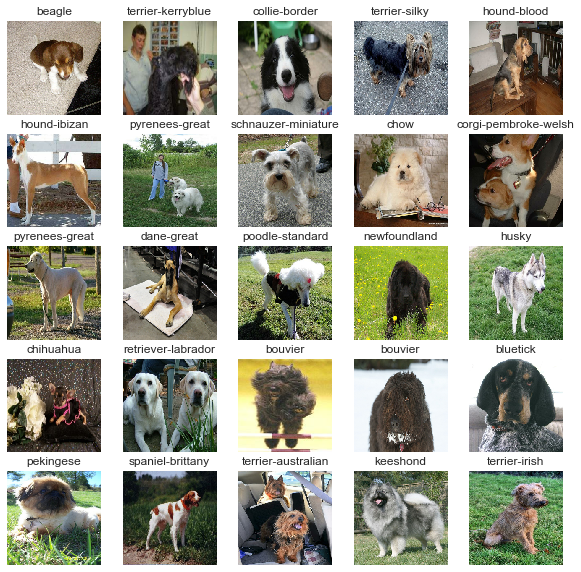

In [28]:
# Visualize training images from the training data batch
train_images, train_labels = next(train_data.as_numpy_iterator())
show_25_images(train_images, train_labels)

In [94]:
# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 173)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('backup/2/images/train')
valid_files, valid_targets = load_dataset('backup/2/images/validation')
test_files, test_targets = load_dataset('backup/2/images/test')

# load list of dog names
dog_names = [item for item in sorted(glob("backup/2/images/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

There are 173 total dog categories.
There are 28669 total dog images.

There are 18553 training dog images.
There are 4309 validation dog images.
There are 5807 test dog images.


In [349]:
test_targets

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [65]:
# Analysis of the number of images in each class
globlist = list(glob("images/train/*/"))

# Extract number of images per class
img_per_class = []
for folder in globlist:
    class_length = (len(folder))
    img_per_class.append(class_length)
print(img_per_class)

# Average number of images per class
print("mean:",np.mean(img_per_class))

print("max:" ,np.max(img_per_class))
print("min:" ,np.min(img_per_class))

[26, 30, 30, 24, 35, 28, 23, 30, 29, 27, 21, 31, 26, 24, 20, 30, 39, 24, 32, 22, 27, 28, 24, 23, 28, 30, 28, 28, 40, 35, 30, 32, 20, 33, 23, 25, 23, 33, 27, 21, 21, 29, 22, 23, 28, 27, 29, 35, 29, 19, 31, 33, 32, 33, 19, 28, 28, 36, 30, 26, 27, 23, 28, 35, 26, 26, 24, 34, 17, 30, 35, 28, 30, 22, 34, 33, 21, 21, 19, 22, 30, 20, 29, 27, 20, 31, 28, 20, 20, 28, 31, 30, 21, 27, 32, 31, 41, 26, 24, 27, 22, 27, 28, 25, 23, 24, 29, 26, 26, 29, 30, 21, 25, 20, 27, 29, 34, 32, 23, 25, 27, 31, 36, 19, 31, 32, 29, 25, 20, 32, 18, 19, 32, 23, 32, 29, 19, 24, 22, 30, 27, 34, 32, 30, 30, 32, 34, 21, 30, 30, 38, 44, 20, 26, 20, 30, 30, 25, 21, 34, 19, 29, 21, 34, 22, 21, 29, 19, 30, 21, 34, 36, 29]
mean: 27.352601156069365
max: 44
min: 17


In [96]:
# Functions that process images before sending to CNN

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [99]:

from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255


 18%|█▊        | 3266/18553 [00:16<01:35, 159.78it/s]


 35%|███▍      | 6480/18553 [00:34<01:02, 194.54it/s]


 51%|█████     | 9432/18553 [00:52<01:13, 124.42it/s]


 67%|██████▋   | 12393/18553 [01:09<00:31, 192.87it/s]


 81%|████████  | 15055/18553 [01:28<00:19, 177.89it/s]


 96%|█████████▌| 17829/18553 [01:46<00:04, 174.87it/s]


100%|██████████| 18553/18553 [01:52<00:00, 165.18it/s]

 37%|███▋      | 1602/4309 [00:14<00:18, 148.07it/s]


100%|██████████| 4309/4309 [00:35<00:00, 121.01it/s][A

  1%|▏         | 82/5807 [00:00<00:41, 137.11it/s]


 55%|█████▍    | 3176/5807 [00:18<00:13, 197.56it/s]


100%|██████████| 5807/5807 [00:38<00:00, 151.86it/s]


In [252]:
test_files

array(['images/test/terrier-boston/z0amboinpfs562teqj48.jpg',
       'images/test/spaniel-welsh/pt34s0zb87adcevwlnhx.jpg',
       'images/test/hound-english/z9rkewyju6dv1lnbaph2.jpg', ...,
       'images/test/hound-afghan/bz2qio1r5akd9ut68fwn.jpg',
       'images/test/mountain-swiss/hf1vnyol8rebgjzi794k.jpg',
       'images/test/papillon/9kuvi5ln0chmoxb17eay.jpg'], dtype='<U67')

In [23]:
train_tensors.shape

(18553, 224, 224, 3)

In [24]:
valid_tensors.shape

(4309, 224, 224, 3)

In [25]:
test_tensors.shape

(5807, 224, 224, 3)

In [39]:
model = Sequential()

# CNN
model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(GlobalAveragePooling2D(input_shape=(28,28,64)))
model.add(Dropout(0.15))

# MLP Frontend
#model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dropout(0.15))
model.add(Dense(173, activation='softmax'))

In [40]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 224, 224, 16)      208       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 112, 112, 32)      2080      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 56, 56, 64)        8256      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
global_average_pooling2d_3 ( (None, 64)               

In [41]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [42]:

### TODO: specify the number of epochs that you would like to use to train the model.

epochs = 30

### Do NOT modify the code below this line.

checkpointer = ModelCheckpoint(filepath='models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

history = model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=32, callbacks=[checkpointer], verbose=1)

Train on 18553 samples, validate on 4309 samples
Epoch 1/30
18553/18553 [==============================] - 349s 19ms/step - loss: 5.0484 - accuracy: 0.0084 - val_loss: 5.0054 - val_accuracy: 0.0146

Epoch 00001: val_loss improved from inf to 5.00538, saving model to models/weights.best.from_scratch.hdf5
Epoch 2/30
18553/18553 [==============================] - 331s 18ms/step - loss: 4.9585 - accuracy: 0.0161 - val_loss: 4.9094 - val_accuracy: 0.0181

Epoch 00002: val_loss improved from 5.00538 to 4.90941, saving model to models/weights.best.from_scratch.hdf5
Epoch 3/30
18553/18553 [==============================] - 322s 17ms/step - loss: 4.8851 - accuracy: 0.0220 - val_loss: 4.8518 - val_accuracy: 0.0246

Epoch 00003: val_loss improved from 4.90941 to 4.85185, saving model to models/weights.best.from_scratch.hdf5
Epoch 4/30
18553/18553 [==============================] - 321s 17ms/step - loss: 4.8035 - accuracy: 0.0282 - val_loss: 4.7610 - val_accuracy: 0.0334

Epoch 00004: val_loss imp

In [35]:
#model.load_weights('models/weights.best.from_scratch.hdf5')

In [43]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 11.3828%


In [41]:
def plot_accuracy(model_fit):
    # Get training and test accuracy histories
    training_accuracy = model_fit.history['accuracy']
    test_accuracy = model_fit.history['val_accuracy']

    # Create count of the number of epochs
    epoch_count = range(1, len(training_accuracy) + 1)

    # Visualize accuracy history
    plt.plot(epoch_count, training_accuracy, 'r--')
    plt.plot(epoch_count, test_accuracy, 'b-')
    plt.legend(['Training Accuracy', 'Test Accuracy'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy Score')
    return plt.show();

In [42]:
def plot_loss(model_fit):
    training_loss = model_fit.history['loss']
    test_loss = model_fit.history['val_loss']

    # Create count of the number of epochs
    epoch_count = range(1, len(training_loss) + 1)

    # Visualize loss history
    plt.plot(epoch_count, training_loss, 'r--')
    plt.plot(epoch_count, test_loss, 'b-')
    plt.legend(['Training Loss', 'Test Loss'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    return plt.show();

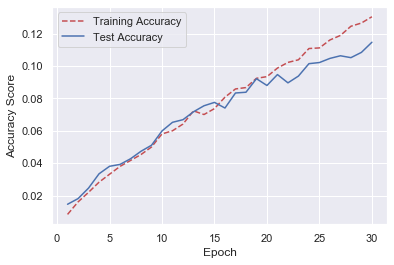

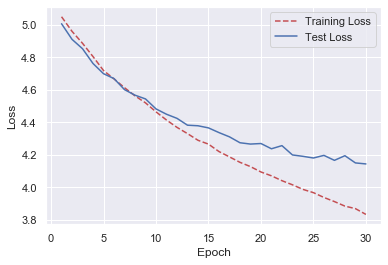

(None, None)

In [47]:
plot_accuracy(history), plot_loss(history)

In [37]:
history.history

AttributeError: 'NoneType' object has no attribute 'history'

In [56]:
###

In [31]:
# Setup input shape to the model
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3] # batch, height, width, colour channels

# Setup output shape of the model
OUTPUT_SHAPE = len(unique_breeds) # number of unique labels

# Setup model URL from TensorFlow Hub
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4"


checkpointer = ModelCheckpoint(filepath='models/weights.best.mobilenet.hdf5', 
                               verbose=1, save_best_only=True)

In [32]:
# Create a function which builds a Keras model
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
  print("Building model with:", MODEL_URL)

  # Setup the model layers
  model = tf.keras.Sequential([
    hub.KerasLayer(MODEL_URL), # Layer 1 (input layer)
    tf.keras.layers.Dense(units=OUTPUT_SHAPE, 
                          activation="softmax") # Layer 2 (output layer)
  ])

  # Compile the model
  model.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(), # Our model wants to reduce this (how wrong its guesses are)
      optimizer=tf.keras.optimizers.Adam(), # A friend telling our model how to improve its guesses
      metrics=["accuracy"] # We'd like this to go up
  )

  # Build the model
  model.build(INPUT_SHAPE) # Let the model know what kind of inputs it'll be getting
  
  return model

In [33]:
# Create a model and check its details
model = create_model()
model.summary()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     multiple                  5432713   
_________________________________________________________________
dense (Dense)                multiple                  173346    
Total params: 5,606,059
Trainable params: 173,346
Non-trainable params: 5,432,713
_________________________________________________________________


In [34]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [35]:
import datetime

# Create a function to build a TensorBoard callback
def create_tensorboard_callback():
  # Create a log directory for storing TensorBoard logs
  logdir = os.path.join("logs/",
                        # Make it so the logs get tracked whenever we run an experiment
                        datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  return tf.keras.callbacks.TensorBoard(logdir)

In [36]:
# Create early stopping (once our model stops improving, stop training)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="accuracy",
                                                  patience=3) # stops after 3 rounds of no improvements

In [37]:
# How many rounds should we get the model to look through the data?
NUM_EPOCHS = 40 #@param {type:"slider", min:10, max:100, step:10}

In [38]:
# Build a function to train and return a trained model
def train_model():
  """
  Trains a given model and returns the trained version.
  """
  # Create a model
  model = create_model()

  # Create new TensorBoard session everytime we train a model
  tensorboard = create_tensorboard_callback()

  # Fit the model to the data passing it the callbacks we created
  model.fit(x=train_data,
            epochs=NUM_EPOCHS,
            validation_data=val_data,
            validation_freq=1, # check validation metrics every epoch
            callbacks=[tensorboard, early_stopping, checkpointer])
  
  return model

In [39]:
# Fit the model to the data
model = train_model()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Train for 500 steps, validate for 125 steps
Epoch 1/40
499/500 [============================>.] - ETA: 0s - loss: 0.8144 - accuracy: 0.7916
Epoch 00001: val_loss improved from inf to 0.45669, saving model to models/weights.best.mobilenet.hdf5
500/500 [==============================] - 399s 799ms/step - loss: 0.8134 - accuracy: 0.7918 - val_loss: 0.4567 - val_accuracy: 0.8597
Epoch 2/40
499/500 [============================>.] - ETA: 0s - loss: 0.2721 - accuracy: 0.9138
Epoch 00002: val_loss did not improve from 0.45669
500/500 [==============================] - 393s 787ms/step - loss: 0.2723 - accuracy: 0.9136 - val_loss: 0.4665 - val_accuracy: 0.8565
Epoch 3/40
499/500 [============================>.] - ETA: 0s - loss: 0.1744 - accuracy: 0.9480
Epoch 00003: val_loss did not improve from 0.45669
500/500 [==============================] - 395s 790ms/step - loss: 0.1746 - accuracy: 0.9478 - val_l

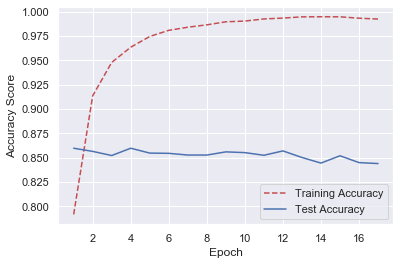

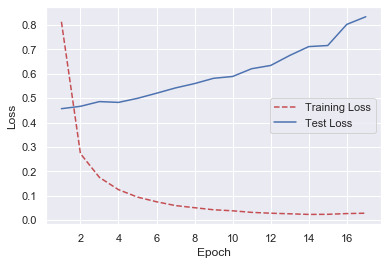

(None, None)

In [43]:
plot_accuracy(model.history), plot_loss(model.history)

# New heading

In [565]:
from os import listdir
from PIL import Image
badfiles = []
for filename in listdir('images/train/'):
    try:
        img = Image.open('images/train/'+filename) # open the image file
        img.verify() # verify that it is, in fact an image
    except (IOError, SyntaxError) as e:
        badfiles.append(filename) # print out the names of corrupt files

In [566]:
len(badfiles)

0

In [44]:
# Setup input shape to the model
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3] # batch, height, width, colour channels

# Setup output shape of the model
OUTPUT_SHAPE = len(unique_breeds) # number of unique labels

# Setup model URL from TensorFlow Hub
MODEL_URL = "https://tfhub.dev/google/imagenet/inception_resnet_v2/classification/4"


checkpointer = ModelCheckpoint(filepath='models/weights.best.inception_resnet.hdf5', 
                               verbose=1, save_best_only=True)

In [45]:
# Create a model and check its details
model = create_model()
model.summary()

Building model with: https://tfhub.dev/google/imagenet/inception_resnet_v2/classification/4
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_2 (KerasLayer)   multiple                  55875273  
_________________________________________________________________
dense_2 (Dense)              multiple                  173346    
Total params: 56,048,619
Trainable params: 173,346
Non-trainable params: 55,875,273
_________________________________________________________________


In [46]:
# Fit the model to the data
model = train_model()

Building model with: https://tfhub.dev/google/imagenet/inception_resnet_v2/classification/4
Train for 500 steps, validate for 125 steps
Epoch 1/40
499/500 [============================>.] - ETA: 2s - loss: 0.6321 - accuracy: 0.8573
Epoch 00001: val_loss improved from inf to 0.53520, saving model to models/weights.best.inception_resnet.hdf5
500/500 [==============================] - 1571s 3s/step - loss: 0.6318 - accuracy: 0.8572 - val_loss: 0.5352 - val_accuracy: 0.8790
Epoch 2/40
499/500 [============================>.] - ETA: 2s - loss: 0.3596 - accuracy: 0.9005
Epoch 00002: val_loss did not improve from 0.53520
500/500 [==============================] - 1372s 3s/step - loss: 0.3596 - accuracy: 0.9006 - val_loss: 0.5777 - val_accuracy: 0.8695
Epoch 3/40
499/500 [============================>.] - ETA: 2s - loss: 0.2956 - accuracy: 0.9126
Epoch 00003: val_loss did not improve from 0.53520
500/500 [==============================] - 1357s 3s/step - loss: 0.2967 - accuracy: 0.9124 - val_l

Epoch 30/40
499/500 [============================>.] - ETA: 2s - loss: 0.0686 - accuracy: 0.9770
Epoch 00030: val_loss did not improve from 0.53520
500/500 [==============================] - 1374s 3s/step - loss: 0.0686 - accuracy: 0.9769 - val_loss: 1.0807 - val_accuracy: 0.8800
Epoch 31/40
499/500 [============================>.] - ETA: 2s - loss: 0.0757 - accuracy: 0.9736
Epoch 00031: val_loss did not improve from 0.53520
500/500 [==============================] - 1408s 3s/step - loss: 0.0757 - accuracy: 0.9736 - val_loss: 1.0607 - val_accuracy: 0.8748
Epoch 32/40
499/500 [============================>.] - ETA: 2s - loss: 0.0771 - accuracy: 0.9734
Epoch 00032: val_loss did not improve from 0.53520
500/500 [==============================] - 1427s 3s/step - loss: 0.0769 - accuracy: 0.9734 - val_loss: 1.1279 - val_accuracy: 0.8712
Epoch 33/40
499/500 [============================>.] - ETA: 2s - loss: 0.0772 - accuracy: 0.9745
Epoch 00033: val_loss did not improve from 0.53520
500/500 [

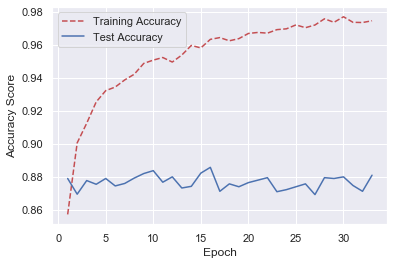

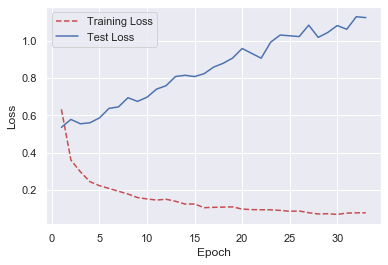

(None, None)

In [47]:
plot_accuracy(model.history), plot_loss(model.history)

In [65]:
def load_model(model_path):
  """
  Loads a saved model from a specified path.
  """
  print(f"Loading saved model from: {model_path}")
  model = tf.keras.models.load_model(model_path,
                                     custom_objects={"KerasLayer":hub.KerasLayer})
  return model

In [67]:
# Load our model trained on 1000 images
model_scratch = load_model('models/weights.best.from_scratch.hdf5')

Loading saved model from: models/weights.best.from_scratch.hdf5


In [68]:
# Evaluate the pre-saved model
model_scratch.evaluate(val_data)

125/125 [==============================] - 28s 220ms/step - loss: 3.7251 - accuracy: 0.1643


[3.7251318740844725, 0.16425]

In [70]:
# Load our model trained on 1000 images
model_resnet = load_model('models/weights.best.inception_resnet.hdf5')

Loading saved model from: models/weights.best.inception_resnet.hdf5


In [71]:
# Evaluate the pre-saved model
model_resnet.evaluate(val_data)

125/125 [==============================] - 341s 3s/step - loss: 0.5352 - accuracy: 0.8790


[0.535201402850449, 0.879]

In [72]:
# Load our model trained on 1000 images
model_mobilenet = load_model('models/weights.best.mobilenet.hdf5')

Loading saved model from: models/weights.best.mobilenet.hdf5


In [73]:
model_mobilenet.evaluate(val_data)

125/125 [==============================] - 102s 815ms/step - loss: 0.4567 - accuracy: 0.8597


[0.45668970131874087, 0.85975]

In [50]:
# Make predictions on the validation data (not used to train on)
predictions = model.predict(val_data, verbose=1) # verbose shows us how long there is to go
predictions

125/125 [==============================] - 286s 2s/step


array([[6.0754749e-20, 1.5691379e-14, 1.7450027e-14, ..., 1.1489279e-14,
        2.3729590e-12, 4.5534881e-13],
       [1.0045395e-09, 2.3506366e-16, 7.2152113e-17, ..., 2.2912056e-16,
        4.9733209e-15, 1.5555864e-15],
       [6.2391814e-11, 2.1872356e-12, 2.8274551e-12, ..., 1.3389544e-12,
        2.0531851e-07, 8.4804689e-12],
       ...,
       [2.3552747e-13, 1.5755431e-16, 8.3948542e-17, ..., 3.8632757e-16,
        6.4885558e-04, 5.9076445e-17],
       [1.8245040e-20, 1.1352662e-19, 1.1154203e-20, ..., 6.9101298e-20,
        9.5386480e-23, 6.0872447e-20],
       [4.5064916e-10, 2.1076184e-14, 1.4764543e-14, ..., 1.4819843e-14,
        2.5997398e-13, 9.5408555e-15]], dtype=float32)

In [52]:
# Check the shape of predictions
predictions.shape

(4000, 173)

In [53]:
# First prediction
print(predictions[0])
print(f"Max value (probability of prediction): {np.max(predictions[0])}") # the max probability value predicted by the model
print(f"Sum: {np.sum(predictions[0])}") # because we used softmax activation in our model, this will be close to 1
print(f"Max index: {np.argmax(predictions[0])}") # the index of where the max value in predictions[0] occurs
print(f"Predicted label: {unique_breeds[np.argmax(predictions[0])]}") # the predicted label

[6.07547487e-20 1.56913785e-14 1.74500273e-14 3.50363998e-14
 6.16559798e-12 1.15726571e-14 1.20785907e-14 5.53590160e-19
 8.89892814e-15 6.36028730e-11 4.31120140e-11 3.28798322e-10
 2.53707103e-14 1.44518674e-12 7.44918636e-15 3.60167273e-13
 2.73663888e-17 3.45164888e-15 1.15410760e-13 1.82248287e-14
 1.19364603e-14 1.35763650e-10 2.51647157e-15 9.39111273e-15
 2.98206555e-14 8.57120229e-14 8.40185838e-11 5.73526273e-16
 1.14012727e-12 5.59077849e-13 4.60328483e-15 9.07042775e-15
 3.83641652e-14 8.36551084e-15 1.20588886e-10 3.34920177e-18
 2.32737922e-14 7.98538481e-14 2.22301616e-15 4.12564973e-15
 2.45167897e-22 7.23538728e-14 6.22897187e-14 1.02661901e-14
 3.26651751e-14 2.97460658e-14 4.45472889e-14 1.92498459e-21
 4.85415473e-14 5.32172113e-16 1.37088615e-14 1.17116628e-14
 8.38487605e-14 1.66651502e-12 7.02647508e-14 5.68862596e-11
 4.62536029e-14 3.88765232e-23 6.94085360e-14 4.30385809e-14
 8.35744116e-15 3.57247928e-24 5.48979502e-15 1.28959745e-19
 2.09984482e-12 2.687386

In [54]:
# Turn prediction probabilities into their respective label (easier to understand)
def get_pred_label(prediction_probabilities):
  """
  Turns an array of prediction probabilities into a label.
  """
  return unique_breeds[np.argmax(prediction_probabilities)]

# Get a predicted label based on an array of prediction probabilities
pred_label = get_pred_label(predictions[0])
pred_label

'retriever-flatcoated'

In [55]:
# Create a function to unbatch a batched dataset
def unbatchify(data):
  """
  Takes a batched dataset of (image, label) Tensors and returns separate arrays
  of images and labels.
  """
  images = []
  labels = []
  # Loop through unbatched data
  for image, label in data.unbatch().as_numpy_iterator():
    images.append(image)
    labels.append(unique_breeds[np.argmax(label)])
  return images, labels

# Unbatchify the validation data
val_images, val_labels = unbatchify(val_data)
val_images[0], val_labels[0]

(array([[[0.51108193, 0.6365721 , 0.78951335],
         [0.51108193, 0.6365721 , 0.78951335],
         [0.51108193, 0.6365721 , 0.78951335],
         ...,
         [0.42808124, 0.4476891 , 0.4712185 ],
         [0.4387717 , 0.42094967, 0.43485013],
         [0.19884598, 0.22839801, 0.22689237]],
 
        [[0.50200456, 0.62749475, 0.7765144 ],
         [0.50200456, 0.62749475, 0.7765144 ],
         [0.50200456, 0.62749475, 0.7765144 ],
         ...,
         [0.42812502, 0.44773287, 0.47126228],
         [0.458328  , 0.4406306 , 0.45450062],
         [0.2121664 , 0.24183291, 0.2403171 ]],
 
        [[0.519319  , 0.6394346 , 0.7884542 ],
         [0.519319  , 0.6394346 , 0.7884542 ],
         [0.519319  , 0.6394346 , 0.7884542 ],
         ...,
         [0.4320028 , 0.45161065, 0.47514006],
         [0.42751274, 0.42354748, 0.44009155],
         [0.22995342, 0.2734836 , 0.2770661 ]],
 
        ...,
 
        [[0.6901961 , 0.6509804 , 0.5529412 ],
         [0.697444  , 0.65822834, 0.56018

In [56]:
def plot_pred(prediction_probabilities, labels, images, n=1):
  """
  View the prediction, ground truth label and image for sample n.
  """
  pred_prob, true_label, image = prediction_probabilities[n], labels[n], images[n]
  
  # Get the pred label
  pred_label = get_pred_label(pred_prob)
  
  # Plot image & remove ticks
  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])

  # Change the color of the title depending on if the prediction is right or wrong
  if pred_label == true_label:
    color = "green"
  else:
    color = "red"

  plt.title("{} {:2.0f}% ({})".format(pred_label,
                                      np.max(pred_prob)*100,
                                      true_label),
                                      color=color)

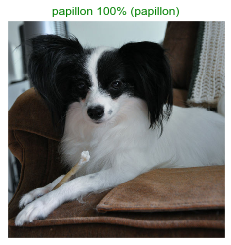

In [59]:
# View an example prediction, original image and truth label
plot_pred(prediction_probabilities=predictions,
          labels=val_labels,
          images=val_images)

In [60]:
def plot_pred_conf(prediction_probabilities, labels, n=1):
  """
  Plots the top 10 highest prediction confidences along with
  the truth label for sample n.
  """
  pred_prob, true_label = prediction_probabilities[n], labels[n]

  # Get the predicted label
  pred_label = get_pred_label(pred_prob)

  # Find the top 10 prediction confidence indexes
  top_10_pred_indexes = pred_prob.argsort()[-10:][::-1]
  # Find the top 10 prediction confidence values
  top_10_pred_values = pred_prob[top_10_pred_indexes]
  # Find the top 10 prediction labels
  top_10_pred_labels = unique_breeds[top_10_pred_indexes]

  # Setup plot
  top_plot = plt.bar(np.arange(len(top_10_pred_labels)), 
                     top_10_pred_values, 
                     color="grey")
  plt.xticks(np.arange(len(top_10_pred_labels)),
             labels=top_10_pred_labels,
             rotation="vertical")

  # Change color of true label
  if np.isin(true_label, top_10_pred_labels):
    top_plot[np.argmax(top_10_pred_labels == true_label)].set_color("green")
  else:
    pass

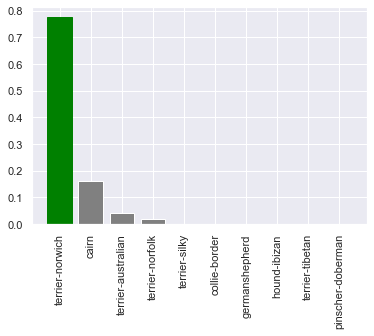

In [61]:
plot_pred_conf(prediction_probabilities=predictions,
               labels=val_labels,
               n=9)

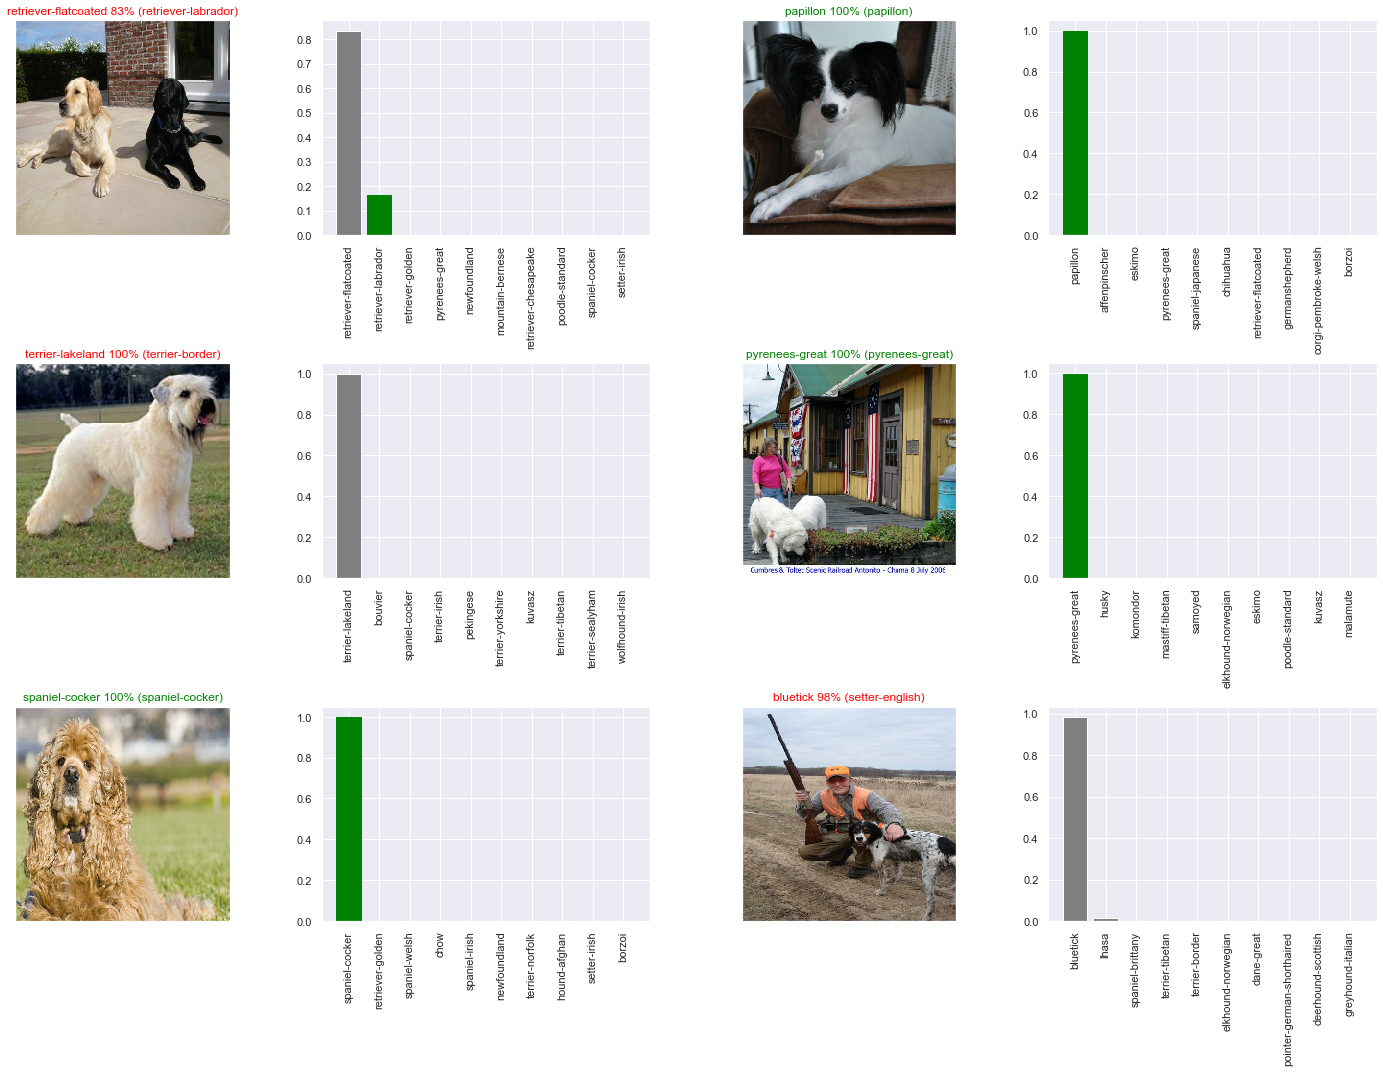

In [64]:
# Let's check a few predictions and their different values
i_multiplier = 0
num_rows = 3
num_cols = 2
num_images = num_rows*num_cols
plt.figure(figsize=(5*2*num_cols, 5*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_pred(prediction_probabilities=predictions,
            labels=val_labels,
            images=val_images,
            n=i+i_multiplier)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_pred_conf(prediction_probabilities=predictions,
                labels=val_labels,
                n=i+i_multiplier)
plt.tight_layout(h_pad=1.0)
plt.show()

In [79]:
# Get custom image filepaths
custom_path = "predict/"
custom_image_paths = [custom_path + fname for fname in os.listdir(custom_path)]

In [80]:
# Turn custom image into batch (set to test data because there are no labels)
custom_data = create_data_batches(custom_image_paths, test_data=True)

Creating test data batches...


In [81]:
# Make predictions on the custom data
custom_preds = model.predict(custom_data)

In [82]:
# Get custom image prediction labels
custom_pred_labels = [get_pred_label(custom_preds[i]) for i in range(len(custom_preds))]
custom_pred_labels

['bulldog-french', 'boxer']

In [83]:
# Get custom images (our unbatchify() function won't work since there aren't labels)
custom_images = []
# Loop through unbatched data
for image in custom_data.unbatch().as_numpy_iterator():
  custom_images.append(image)

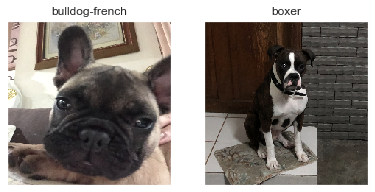

In [84]:
# Check custom image predictions
plt.figure(figsize=(10, 10))
for i, image in enumerate(custom_images):
  plt.subplot(1, 3, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.title(custom_pred_labels[i])
  plt.imshow(image)

In [ ]:
dummy

In [87]:
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.dummy import DummyClassifier

In [139]:
most_freq_train = []
most_freq_test = []

i = 0
while i < len(valid_files):
    most_freq_test.append([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False])
    i += 1
    
i = 0
while i < len(train_files):
    most_freq_train.append([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False])
    i += 1    

In [143]:
def judge_model(model, name):
    print(name)
    print('-'*20)
    
    if strategy == 'most_frequent':
            
        print('Training Performance')
        print('-> Acc:', accuracy_score(train_targets, most_freq_train) )
    
        print('Testing Performance')
        print('-> Acc:', accuracy_score(valid_targets, most_freq_test) )
        print()
    
    else:
        print('Training Performance')
        print('-> Acc:', accuracy_score(train_targets, model.predict(train_files)) )
    
        print('Testing Performance')
        print('-> Acc:', accuracy_score(valid_targets, model.predict(valid_files)) )
        print()


In [144]:
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve


In [145]:
# Baseline (AUC should be 0.5 because we're guessing even though the accuracies are different)
for strategy in ['stratified', 'most_frequent', 'prior', 'uniform']:
    dummy = DummyClassifier(strategy=strategy)
    dummy.fit(train_files, train_targets)
    judge_model(dummy, 'Dummy {}'.format(strategy))

Dummy stratified
--------------------
Training Performance
-> Acc: 0.0028566808602382364
Testing Performance
-> Acc: 0.0016245068461359943

Dummy most_frequent
--------------------
Training Performance
-> Acc: 0.01088772705222875
Testing Performance
-> Acc: 0.010907403109770248

Dummy prior
--------------------
Training Performance
-> Acc: 0.0
Testing Performance
-> Acc: 0.0

Dummy uniform
--------------------
Training Performance
-> Acc: 0.0
Testing Performance
-> Acc: 0.0



In [126]:
len(valid_files)

4309

In [129]:
accuracy_score(valid_targets, most_freq) 

0.010907403109770248

In [138]:
len(train_files)

18553